In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
core_count = 12

Running on PyMC3 v3.8


In [2]:
def SuperNova_CurveRise(t, A, B, t0, trise):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))
def SuperNova_CurveFall(t, A, B, t0, t1, trise, tfall):
    return (A + B*(t1-t0))*np.exp(-(t-t1)/tfall)/(1+np.exp(-(t-t0)/trise))

In [3]:
#These are the values we are going to use for a test
np.random.seed(212)
trise_A = 9.1
tfall_A = 13
Amplitude_A = 1500
Beta_A = -.8
t0_A = 43.2
t1_A = 133.2
end_A = 500
size = 10 #data set size double for total observations
sigma_A = 100 #Telescope error

In [4]:
time_axis_rise = np.random.uniform(low=0, high=t1_A, size=size)
time_axis_rise = np.sort(time_axis_rise)
time_axis_fall = np.random.uniform(low=t1_A, high=end_A, size=size)
time_axis_fall = np.sort(time_axis_fall)
Y_actual_rise = SuperNova_CurveRise(time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A)
Y_actual_fall = SuperNova_CurveFall(time_axis_fall, Amplitude_A, Beta_A, t0_A, t1_A, trise_A, tfall_A)
time_axis = np.append(time_axis_rise, time_axis_fall)
Y_actual = np.append(Y_actual_rise, Y_actual_fall)
Y_observed = Y_actual + np.random.normal(0,sigma_A, len(Y_actual))
#Y_observed = Y_actual

Text(0.5, 1.0, 'Actual Light Curve')

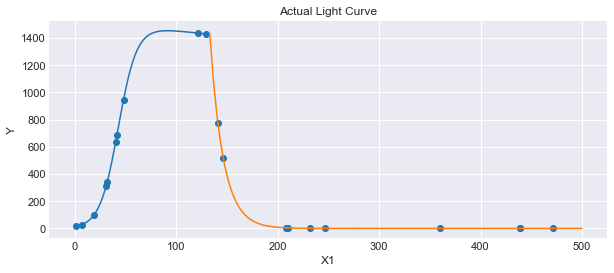

In [5]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
axes.scatter(time_axis, Y_actual)

big_time_axis_rise = np.linspace(0,t1_A,num = 100)
axes.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A))

big_time_axis_fall = np.linspace(t1_A,end_A,num = 100)
axes.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_A, Beta_A, t0_A, t1_A, trise_A, tfall_A))

axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Actual Light Curve")

Text(0.5, 1.0, 'Observed Light Curve')

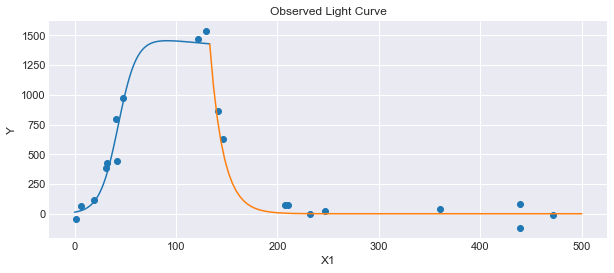

In [6]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
axes.scatter(time_axis, Y_observed)

big_time_axis_rise = np.linspace(0,t1_A,num = 100)
axes.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A))

big_time_axis_fall = np.linspace(t1_A,end_A,num = 100)
axes.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_A, Beta_A, t0_A, t1_A, trise_A, tfall_A))

axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Observed Light Curve")

(141.1345764577141, -16.21650134735763)


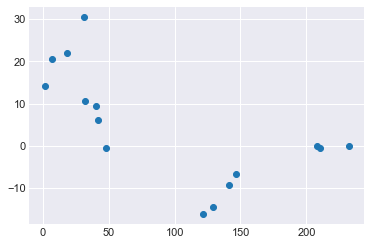

In [7]:
step = int(np.ceil(size/2))
if step<1:
    step = 1
slopes = []
least_slope = (0, 0)
for i in range(len(time_axis)-step):
    if step > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(time_axis[i:i+step],Y_observed[i:i+step])
    else:
        slope = (Y_observed[i]-Y_observed[i+step])/(time_axis[i]-time_axis[i+step])
    slopes.append(slope)
    if(slope < least_slope[1]):
        least_slope = (time_axis[i+int(np.floor(step/2))], slope)
print(least_slope)
plt.scatter(time_axis[0:len(time_axis)-step], slopes)

In [8]:
basic_model = pm.Model()

In [9]:
with basic_model:

    # Priors for unknown model parameters
    
    trise = pm.Uniform('trise', lower = 0.01, upper = 50)
    tfall = pm.Uniform('tfall', lower = 1, upper = 300)
    Amp_Guess = np.max(Y_observed)-np.min(Y_observed)
    Amplitude = pm.Normal('Amplitude', mu=Amp_Guess, sigma=Amp_Guess/2)
    Beta = pm.Uniform('Beta', lower = -np.max(Y_observed)/150, upper = 0)
    t0 = pm.Uniform('t0', lower = np.min(time_axis), upper = np.max(time_axis))
    sigma = pm.HalfNormal('sigma', sigma=sigma_A)
    
    t1 = pm.Uniform('t1', lower = np.min(time_axis), upper = np.max(time_axis), testval = least_slope[0])
    
    # Expected value of outcome
    mu_rise = SuperNova_CurveRise(time_axis, Amplitude, Beta, t0, trise)
    mu_fall = SuperNova_CurveFall(time_axis, Amplitude, Beta, t0, t1, trise, tfall)
    
    mu_switch = pm.math.switch(t1 >= time_axis, mu_rise, mu_fall)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed)

In [10]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -169.32, ||grad|| = 0.0080039: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 2333.63it/s]


{'trise_interval__': array(-1.25550814),
 'tfall_interval__': array(-18.40587741),
 'Amplitude': array(1906.79505115),
 'Beta_interval__': array(-17.4078964),
 't0_interval__': array(-2.18831089),
 'sigma_log__': array(5.07976074),
 't1_interval__': array(-0.14342671),
 'trise': array(11.09518802),
 'tfall': array(1.00000303),
 'Beta': array(-10.25388881),
 't0': array(48.7656813),
 'sigma': array(160.7355943),
 't1': array(219.7592413)}

In [11]:
with basic_model:
    # 1000 posterior samples
    trace = pm.sample(10000, cores = 6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [t1, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 6 chains, 1 divergences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63000/63000 [01:08<00:00, 913.16draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9064078637414092, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotl

C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotl

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5E1E6B3C8>,
      dtype=object)

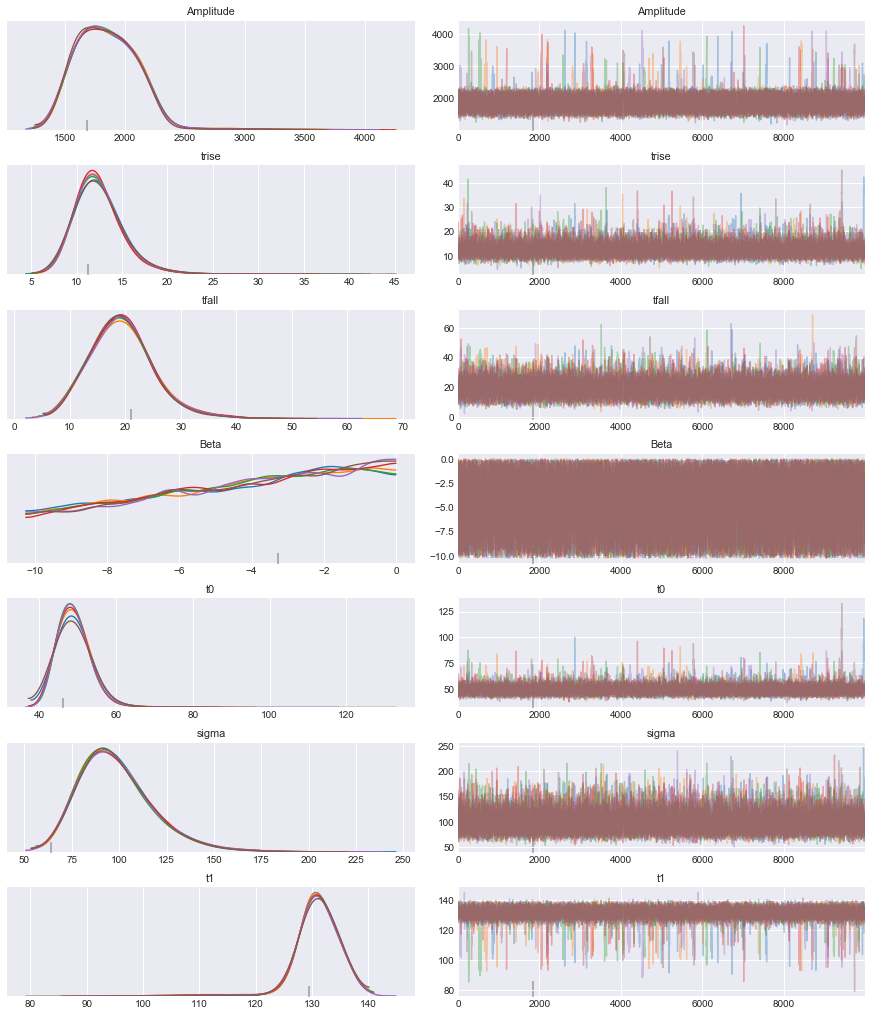

In [12]:
%matplotlib inline
pm.traceplot(trace)

In [13]:
summary_table = pm.summary(trace)
summary_table

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Amplitude,1862.395,257.097,1467.523,2252.748,2.941,2.257,7640.0,6491.0,11333.0,7417.0,1.0
trise,12.551,2.668,8.151,17.328,0.021,0.017,16515.0,12628.0,23885.0,17974.0,1.0
tfall,19.449,5.713,8.844,29.896,0.055,0.044,10881.0,8567.0,13429.0,7353.0,1.0
Beta,-4.532,2.891,-9.349,-0.000,0.021,0.015,18871.0,18871.0,19007.0,29723.0,1.0
t0,49.181,4.498,41.918,56.689,0.048,0.035,8908.0,8052.0,12177.0,10830.0,1.0
sigma,98.714,19.427,66.736,135.803,0.161,0.117,14571.0,13885.0,16403.0,18967.0,1.0
t1,130.734,4.638,125.518,138.087,0.071,0.050,4267.0,4267.0,11316.0,4456.0,1.0


In [14]:
trise_R = summary_table["mean"]["trise"]
tfall_R = summary_table["mean"]["tfall"]
Amplitude_R = summary_table["mean"]["Amplitude"]
Beta_R = summary_table["mean"]["Beta"]
t0_R = summary_table["mean"]["t0"]
t1_R = summary_table["mean"]["t1"]

In [15]:
print(trise_R, trise_A)
print(tfall_R, tfall_A)
print(Amplitude_R, Amplitude_A)
print(Beta_R, Beta_A)
print(t0_R, t0_A)
print(t1_R, t1_A)

12.551 9.1
19.449 13
1862.395 1500
-4.532 -0.8
49.181 43.2
130.734 133.2


Text(0, 0.5, 'y_observed')

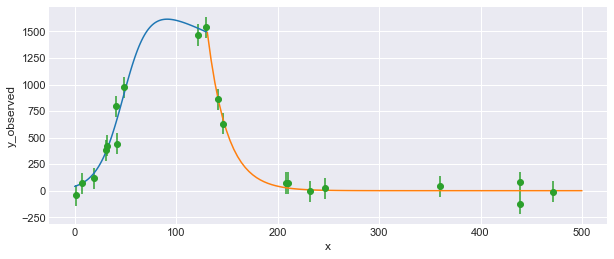

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))

big_time_axis_rise = np.linspace(0,t1_R,num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R, Beta_R, t0_R, trise_R))

big_time_axis_fall = np.linspace(t1_R,end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R, Beta_R, t0_R, t1_R, trise_R, tfall_R))

ax.errorbar(time_axis, Y_observed, sigma_A, fmt='o')
ax.set_xlabel('x')
ax.set_ylabel('y_observed')

Text(0, 0.5, 'y_actual')

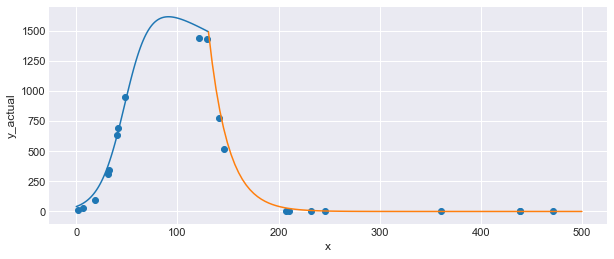

In [17]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))

big_time_axis_rise = np.linspace(0,t1_R,num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R, Beta_R, t0_R, trise_R))

big_time_axis_fall = np.linspace(t1_R,end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R, Beta_R, t0_R, t1_R, trise_R, tfall_R))

ax.scatter(time_axis, Y_actual)
ax.set_xlabel('x')
ax.set_ylabel('y_actual')